In [1]:
%matplotlib inline
%load_ext autoreload
import numpy as np
import pandas as pd
import matplotlib
from sioLoad import loadSIO 
from beamforming import timeDomain
from kam11 import context, matchedField
from kam11.plotting import mfPlotting
import matplotlib.pyplot as plt
import scipy.signal as sig
import os
import datetime as dt

In [2]:
# Beamform on a broadside lfm signal
thetaRange = (-90, 90)
numTheta = 1000
beamformerTime = 6  # ms
c = 1500  # m/s
numEl = 16
# dr = 3.75  # m


# probe signal file
probeSignal = '/Users/edwardlrichards/Documents/data/KAM11/'+\
              'acousticFiles/probeSignals/TX1W_S02_N01_R09_TR_V01.sio'
lfmInfo = context.LFM_Info()
probeSignal = loadSIO.load_selection(probeSignal,
                                          lfmInfo.startingSample, 
                                          lfmInfo.dutyCycleSamples,
                                          [0])['data']
probeSignal = np.squeeze(probeSignal)

# data is loaded to look at frequency of received signal
timeOfInterest='2011 J184 03:51:15'
loadDuration=dt.timedelta(0,1)

# Half lambda spacing
dr = c / lfmInfo.fc / 2

#figure saving
figSaveDir='/Users/edwardlrichards/cir_processing/lfmBeamformer'

In [21]:
lfmInfo.fc + lfmInfo.bw/2

34500.0

In [3]:
lookTheta = np.r_[thetaRange[0] : thetaRange[1] : numTheta * 1j]
eleZ = np.arange(numEl) * dr
eleZ -= np.median(eleZ)

q = (1 / c) * np.sin(np.radians(lookTheta))
delay = eleZ[:, None] * q[None, :]
delay = pd.DataFrame(delay.T, index = lookTheta, columns = eleZ)

In [4]:
# Generate a time series at the times the length of the beamformer
tAxis = np.arange(probeSignal.size) / context.fs
dataSet = np.tile(probeSignal, (numEl, 1)).T
dataSet = pd.DataFrame(dataSet, index=tAxis)

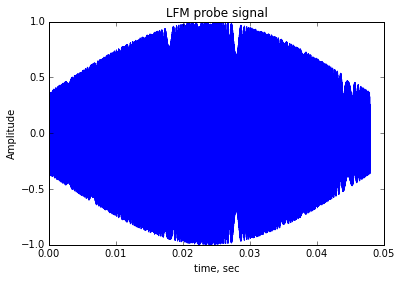

In [5]:
_=plt.plot(tAxis, probeSignal)
_=plt.title('LFM probe signal')
_=plt.xlabel('time, sec')
_=plt.ylabel('Amplitude')

In [6]:
filterTaps = np.flipud(probeSignal)
matchedFilter = np.apply_along_axis(sig.fftconvolve, 0,
                                    np.array(dataSet),
                                    filterTaps)
# Center time at 0 seconds
t_mf = np.arange(matchedFilter.shape[0]) / context.fs 
t_mf -= np.median(t_mf)
matchedFilter = pd.DataFrame(matchedFilter, index=t_mf)

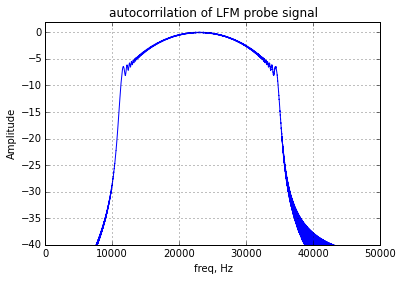

In [7]:
# Plot fft of matched filter output
mf = matchedFilter.iloc[:,0]
NFFT = int(2 ** np.ceil(np.log2(mf.size)))
fAxis = np.arange(NFFT) / NFFT * context.fs - context.fs / 2
fSignal = np.fft.fftshift(np.fft.fft(mf, NFFT))
fSignal = 10 * np.log10(np.abs(fSignal))
fSignal -= np.max(fSignal)
_=plt.plot(fAxis, fSignal)
_=plt.xlim(0,50e3)
_=plt.ylim(-40,2)
_=plt.grid()
_=plt.title('autocorrilation of LFM probe signal')
_=plt.xlabel('freq, Hz')
_=plt.ylabel('Amplitude')

In [8]:
# look at frequency content of received signal
tof = dt.datetime.strptime(timeOfInterest, '%Y J%j %H:%M:%S')
snapshotIndex=5
cirEstimate=matchedField.LFM_MatchedFilter(tof,
                                           loadDuration=loadDuration)
mf=cirEstimate.matchedFilter(baseBand=False)
fastTime=mf[mf['channelNames'][0]].index

def getSingleSnap():
    for m in mf['channelNames']:
        yield(mf[m].iloc[:,snapshotIndex])
lookData=pd.DataFrame(list(getSingleSnap()),\
        index=mf['channelNames'],columns=fastTime).T

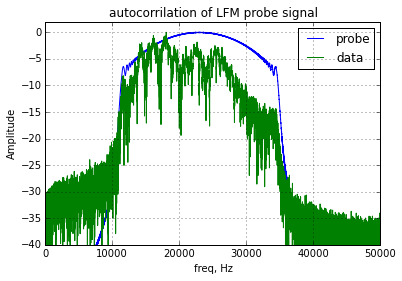

In [9]:
mf = matchedFilter.iloc[:,0]
NFFT = int(2 ** np.ceil(np.log2(mf.size)))
fAxis = np.arange(NFFT) / NFFT * context.fs - context.fs / 2
fSignal = np.fft.fftshift(np.fft.fft(mf, NFFT))
fSignal = 10 * np.log10(np.abs(fSignal))
fSignal -= np.max(fSignal)
_=plt.plot(fAxis, fSignal, label='probe')


mfData = lookData.iloc[:,0]
NFFT = int(2 ** np.ceil(np.log2(mfData.size)))
fAxis = np.arange(NFFT) / NFFT * context.fs - context.fs / 2
fSignal = np.fft.fftshift(np.fft.fft(mfData, NFFT))
fSignal = 10 * np.log10(np.abs(fSignal))
fSignal -= np.max(fSignal)
_=plt.plot(fAxis, fSignal, label='data')
_=plt.xlim(0,50e3)
_=plt.ylim(-40,2)
_=plt.grid()
_=plt.title('autocorrilation of LFM probe signal')
_=plt.xlabel('freq, Hz')
_=plt.ylabel('Amplitude')
_=plt.legend()
savetitle='fft_lfm'
plt.savefig(os.path.join(figSaveDir, savetitle))

In [10]:
#Data beamforming
numLookTimes = beamformerTime / 1e3 * context.fs
lookTimes = np.arange(numLookTimes) / context.fs
lookTimes -= np.median(lookTimes)

In [11]:
beamD=timeDomain.timeBeamformer(matchedFilter, lookTimes,
                                delay, upsample=1)

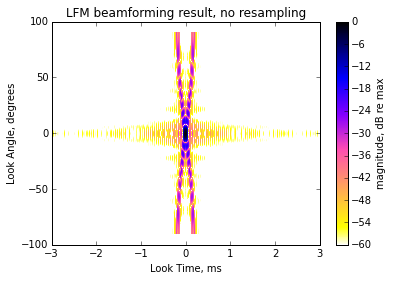

In [19]:
X,Y=np.meshgrid(1e3 * beamD.index, beamD.columns)
beamDB = 20 * np.log10(np.abs(np.array(beamD)))
beamDB -= np.max(beamDB)
_=plt.pcolormesh(X,Y,beamDB.T, cmap=plt.cm.gnuplot2_r, vmin=-60)
_=plt.ylabel('Look Angle, degrees')
_=plt.xlabel('Look Time, ms')
_=plt.title('LFM beamforming result, no resampling')
cb=plt.colorbar()
_=cb.set_label('magnitude, dB re max')
savetitle='bf_1x_lfm_allTime'
plt.savefig(os.path.join(figSaveDir, savetitle))

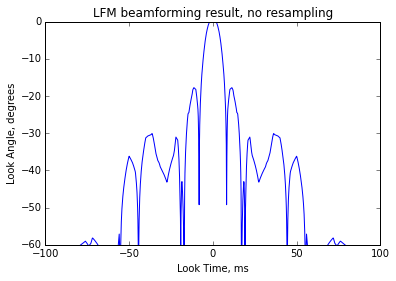

In [13]:
_=plt.plot(beamD.columns, beamDB[int(beamD.shape[0]/2), :])
_=plt.ylim(-60,0)
_=plt.ylabel('Look Angle, degrees')
_=plt.xlabel('Look Time, ms')
_=plt.title('LFM beamforming result, no resampling')
savetitle='bf_1x_lfm_cTime'
plt.savefig(os.path.join(figSaveDir, savetitle))

In [14]:
beamD=timeDomain.timeBeamformer(matchedFilter, lookTimes,
                                delay, upsample=10)

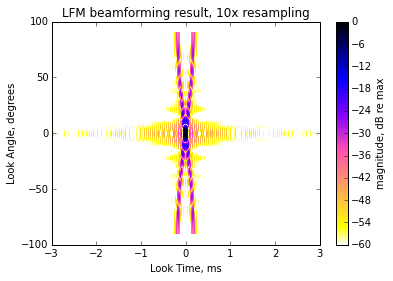

In [20]:
X,Y=np.meshgrid(1e3 * beamD.index, beamD.columns)
beamDB = 20 * np.log10(np.abs(np.array(beamD)))
beamDB -= np.max(beamDB)
_=plt.pcolormesh(X,Y,beamDB.T, cmap=plt.cm.gnuplot2_r, vmin=-60)
_=plt.ylabel('Look Angle, degrees')
_=plt.xlabel('Look Time, ms')
_=plt.title('LFM beamforming result, 10x resampling')

cb=plt.colorbar()
_=cb.set_label('magnitude, dB re max')
savetitle='bf_10x_lfm_allTime'
plt.savefig(os.path.join(figSaveDir, savetitle))

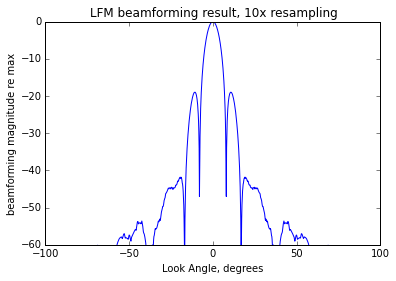

In [16]:
_=plt.plot(beamD.columns, beamDB[int(beamD.shape[0]/2), :])
_=plt.ylim(-60,0)
savetitle='bf_10x_lfm_cTime'
_=plt.xlabel('Look Angle, degrees')
_=plt.ylabel('beamforming magnitude re max')
_=plt.title('LFM beamforming result, 10x resampling')
plt.savefig(os.path.join(figSaveDir, savetitle))